# 2. Feature Extraction

In this notebook we will extract various audio features for a sample of audio. We will focus on the time domain features of:

- Amplitude Envelope 
- Root-Mean-Squared Energy
- Zero Crossing Rate

The frequency domain features of:

- Band Energy Ratio
- Spectral Centroid
- Bandwidth
- Mel Frequency Cepstral Coefficients

And the pitch curve features of:
- Minimum Pitch
- Maximum Pitch
- Pitch Range
- Number of Change Points

In [1]:
#import essentia
#import essentia.stardard as es
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import sklearn

from IPython.display import Audio

## 2.1 Load Samples

Before beginning let's load a single performance audio. If computing power is a limitation you might want to consider loading the entire audio and taking a sample to work with for this notebook.

Hint: `librosa.load` might be useful

In [2]:
audio_path = '../../../data/raw/Koti Janmani/Koti Janmani.mp3.mp3'
sampling_rate = 44100
audio_time_series, _ = librosa.load(audio_path, sr=sampling_rate)

In [3]:
# load one individual sample between 22 and 25 seconds
sample = audio_time_series[22*sampling_rate:round(25*sampling_rate)]


Are you able to listen to this audio and plot the waveform.

**Hint**: You should find that the `Ipythoon.display.Audio` useful for playing audio inline in a Jupyter notebook.

**Hint**: Using the `matplotlib` library you can plot on two dimensions as so:

```
import matplotlib.pyplot as plt

plt.plot(x, y)
```
More information on enhancing these plots (e.g. with titles, axis labels and gridlines) can be found [here](https://matplotlib.org/stable/gallery/lines_bars_and_markers/simple_plot.html).

In [4]:
# Listen to audio
Audio(data=sample, rate=sampling_rate)

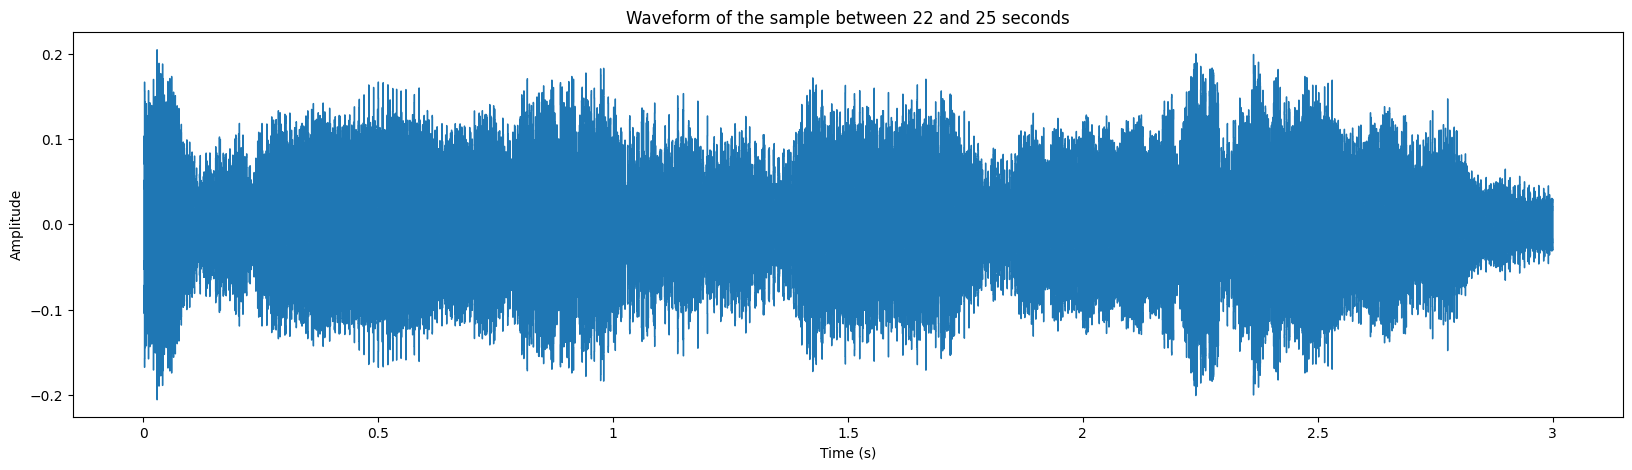

In [5]:
# plot waveform
plt.figure(figsize=(20, 5))
librosa.display.waveshow(sample, sr=sampling_rate)
plt.title('Waveform of the sample between 22 and 25 seconds')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## 2.1 Time Domain Features

Here we will extract the time domain features of:

- Amplitude Envelope 
- Root-Mean-Squared Energy
- Zero Crossing Rate

We will work with the *time domain* representation of your audio (i.e. the amplitude values loaded by your loader).

### 2.1.1 Amplitude Envelope

The amplitude is computed by splitting the  audio into frames and taking the maximum amplitude value for each frame...

![title](images/amplitude_envelope.png)

Try and split your audio into frames of length `w`. 

**Hint**: `numpy` indexing you to take windows of size `w` from an array using `np.array_split(array, w)`.

In [6]:
# Split audio array
length = 0.1
w_size = int(sampling_rate * length)
num_of_windows = int(len(sample) / w_size)

sample_split = np.array_split(sample, num_of_windows)

len(sample_split)

30

Take the maximum value for each window using `np.max()`.

**Hint** A list comprehension may be useful here: `[<f(x)> for x in <iterable>]` where `<iterable>` is some iterable object and `<f(x)>` is some functon to apply to each  element of that iterable.

In [7]:
# Get amplitude envelope by taking the max of the values of the split array
sample_envelope = np.array([np.max(np.abs(x)) for x in sample_split])
len(sample_envelope) # == num_of_windows

30

Can you plot this envelope using `matplotlib.pyplot`. How does it compare with the original signal?

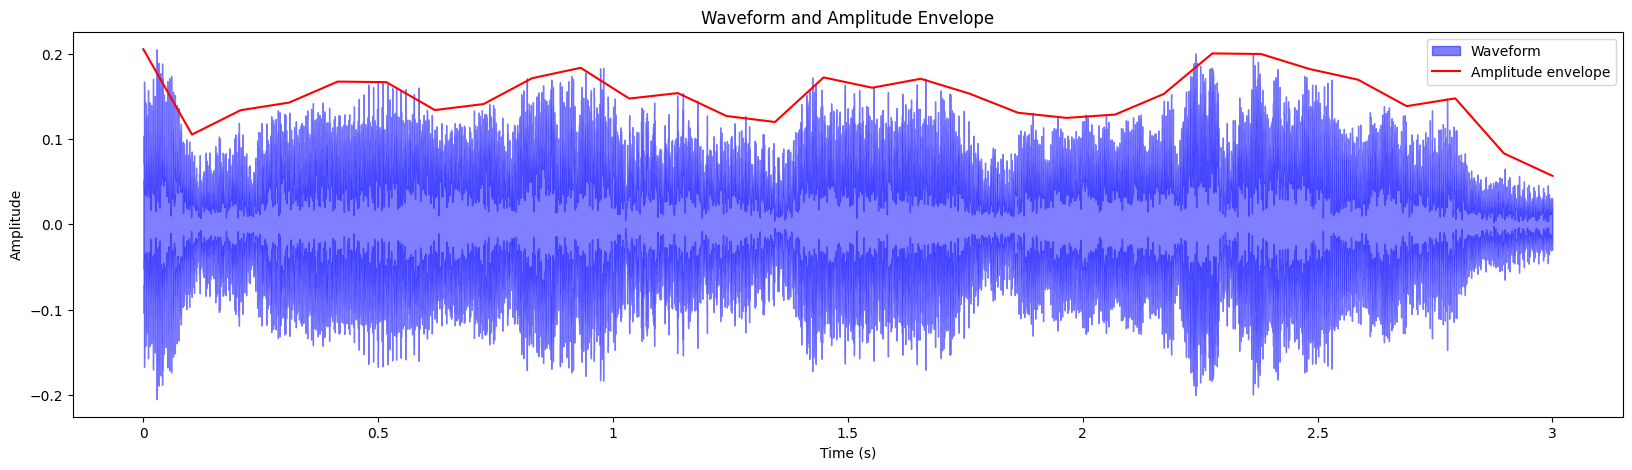

In [8]:
# Compare amplitude envelope with original sample waveform

plt.figure(figsize=(20, 5))

# Plot original waveform
librosa.display.waveshow(sample, sr=sampling_rate, alpha=0.5, label='Waveform', color='blue')

# Plot amplitude envelope
envelope_time = np.linspace(0, len(sample) / sampling_rate, num_of_windows) # between 0 and 3 seconds and 30 points in it, one for each window maximum
plt.plot(envelope_time, sample_envelope, label='Amplitude envelope', color='red')

plt.title('Waveform and Amplitude Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 2.1.2 Root Mean Square Energy

The RMS energy is computed using

![title](images/rms_energy.png)

The `librosa` libray has an implementation at `librosa.feature.rms`

In [9]:
#Funció Miquel manual

def rms(x):
    sum = 0
    for val in x:
        sum += val**2
    rms = np.sqrt(sum/len(x))
    return rms

In [10]:
# import librosa rms
from librosa.feature import rms

In [11]:
# extract rms value
rms_audio = rms(y=sample)[0]

rms_time = np.linspace(0, len(sample) / sampling_rate, len(rms_audio))

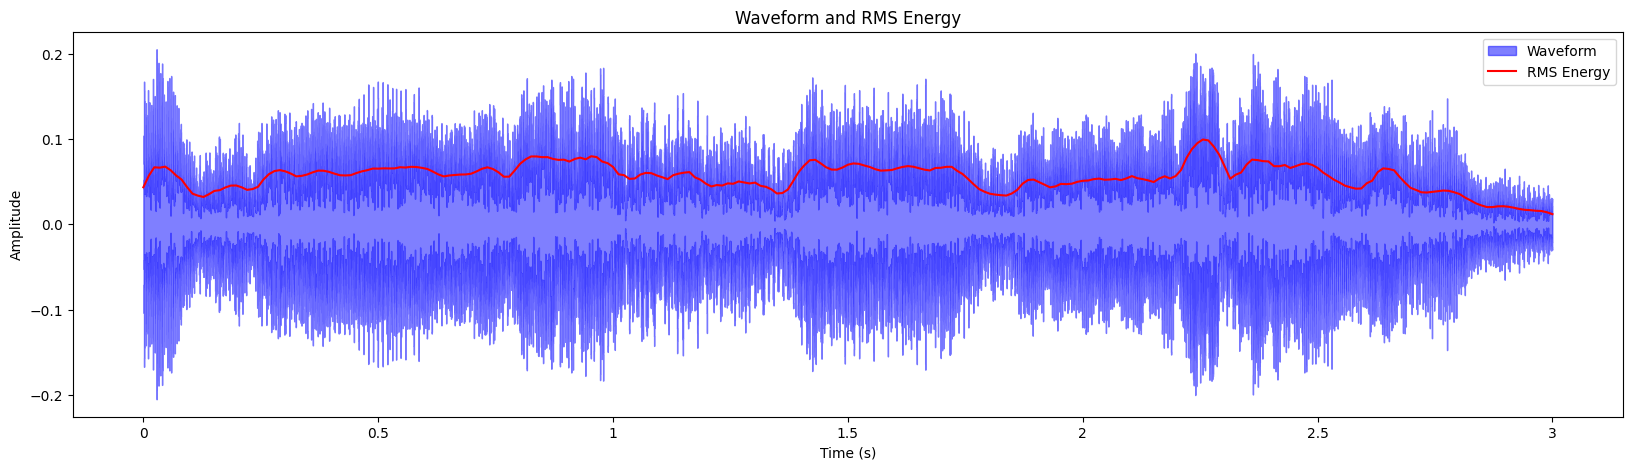

In [12]:
# plot rms
plt.figure(figsize=(20, 5))

# Plot original waveform
librosa.display.waveshow(sample, sr=sampling_rate, alpha=0.5, label='Waveform', color='blue')

# Plot RMS Energy
plt.plot(rms_time, rms_audio, color='red', label='RMS Energy')

plt.title('Waveform and RMS Energy')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 2.1.3 Zero Crossing Rate

The zero crossing rate is the number of times the signal crosses the x axis

![title](images/zero_crossing_graph.png)

It is computed with the following equation

![title](images/zero_crossing_eq.png)

The `librosa` library provides an implementaton at `librosa.feature.zero_crossing_rate`

In [13]:
# import librosa zero_crossing_rate
from librosa.feature import zero_crossing_rate as zcr

In [14]:
#Computing ZERO-CROSSING RATE
# Zooming in (won't be necessary when segmentation is done)
n0 = 9000
n1 = 9100
zero_crossings = librosa.zero_crossings(sample, pad=False)
print(sum(zero_crossings))

5694


In [15]:
# compute ZCR
zcr_audio = zcr(y=sample)[0]

zcr_time = np.linspace(0, len(sample) / sampling_rate, len(zcr_audio))

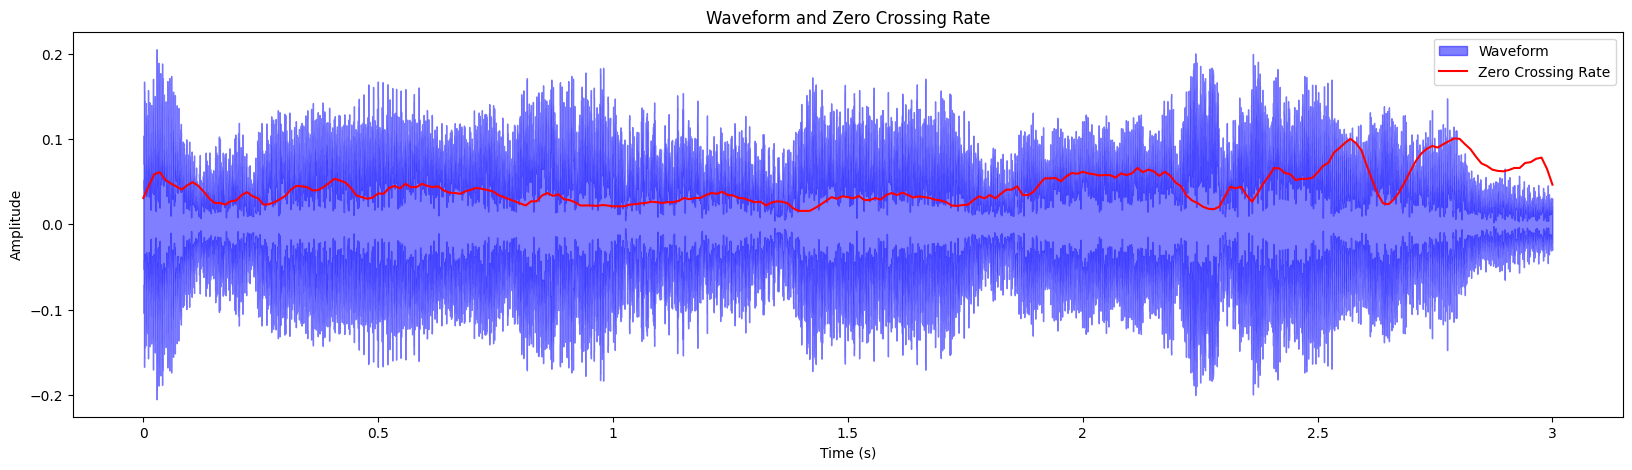

In [16]:
plt.figure(figsize=(20, 5))

# Plot original waveform
librosa.display.waveshow(sample, sr=sampling_rate, alpha=0.5, label='Waveform', color='blue')

# Plot Zero Crossing Rate
plt.plot(zcr_time, zcr_audio, color='red', label='Zero Crossing Rate')

plt.title('Waveform and Zero Crossing Rate')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## 2.2 Frequency Domain Features

Here we will extract the frequency domain features of:

- Band Energy Ratio
- Spectral Centroid
- Bandwidth
- Mel Frequency Cepstral Coefficients

We will work with the **frequency domain** representation of your audio (i.e. the frequency magnitude extracted from the fourier transform of your time domain signal).

Almost all implementations of these feature extractors will compute the frequency domain spectrum for you.

### 2.2.1 Band Energy Ratio

Band energy ratio is the ratio of energy between lower and higher frequency bands divided by some threshold, `F`.

![title](images/bre_spec.png)

![title](images/bre_eq.png)

The `essentia` library provides an implementation for computing the BER at `essentia.standard.EnergyBandRatio`. Import it and extract for your signal.

In [17]:
# import essentia
#import essentia
#import essentia.standard as es
#from essentia import essentia.standard.EnergyBandRatio as ber

In [18]:
# compute BER
def compute_band_energy_ratio(y, sr, fmin, fmax):
    # Compute the Short-Time Fourier Transform (STFT)
    S = np.abs(librosa.stft(y))**2
    
    # Get the frequency values for each bin
    freqs = librosa.fft_frequencies(sr=sr)
    
    # Find the indices corresponding to the specified frequency band
    band_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    
    # Compute the energy in the specified frequency band
    band_energy = np.sum(S[band_indices, :], axis=0)
    
    # Compute the total energy
    total_energy = np.sum(S, axis=0)
    
    # Compute the Band Energy Ratio
    ber = band_energy / total_energy
    
    return ber, total_energy, band_energy

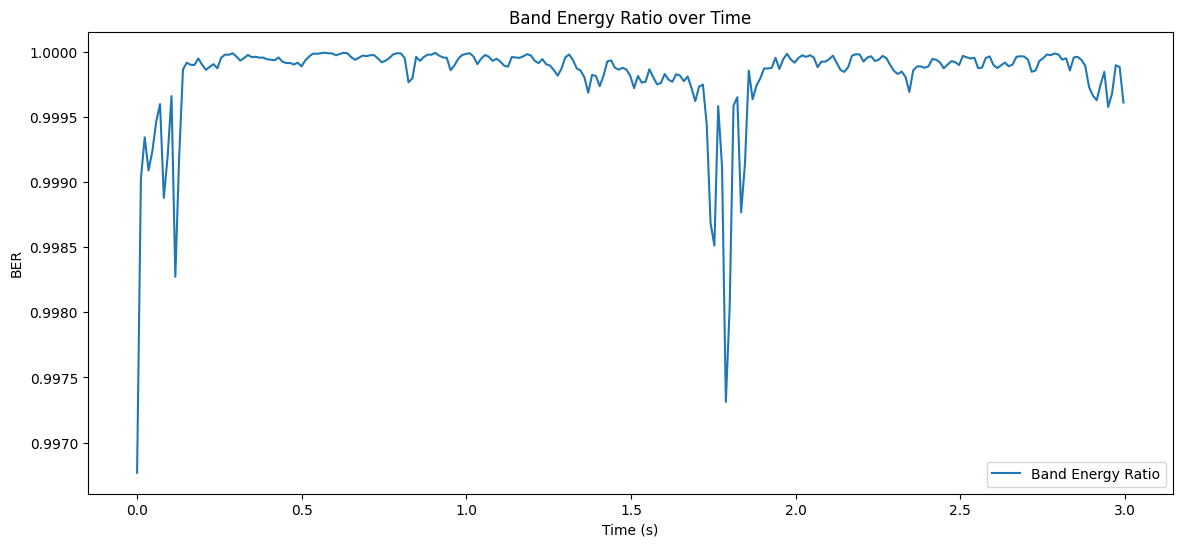

In [19]:
# Define the frequency band (for example, 300 Hz to 3000 Hz)
fmin = 80
fmax = 20000

# Compute the Band Energy Ratio
ber, total_energy, band_energy = compute_band_energy_ratio(sample, sampling_rate, fmin, fmax)

# Generate a time array for plotting
times = librosa.times_like(ber, sr=sampling_rate)

# Plot the Band Energy Ratio over time
plt.figure(figsize=(14, 6))
plt.plot(times, ber, label='Band Energy Ratio')
plt.xlabel('Time (s)')
plt.ylabel('BER')
plt.title('Band Energy Ratio over Time')
plt.legend()
plt.show()

### 2.2.2 Spectral Centroid

The spectral centroid is a weighted mean of energy across all frequency bands. It is computed as:

![title](images/spec_cent.png)

The `librosa` libary provides an implementation at `librosa.feature.spectral_centroid`.

In [20]:
# import librosa implementation
from librosa.feature import spectral_centroid as sc
from sklearn import preprocessing


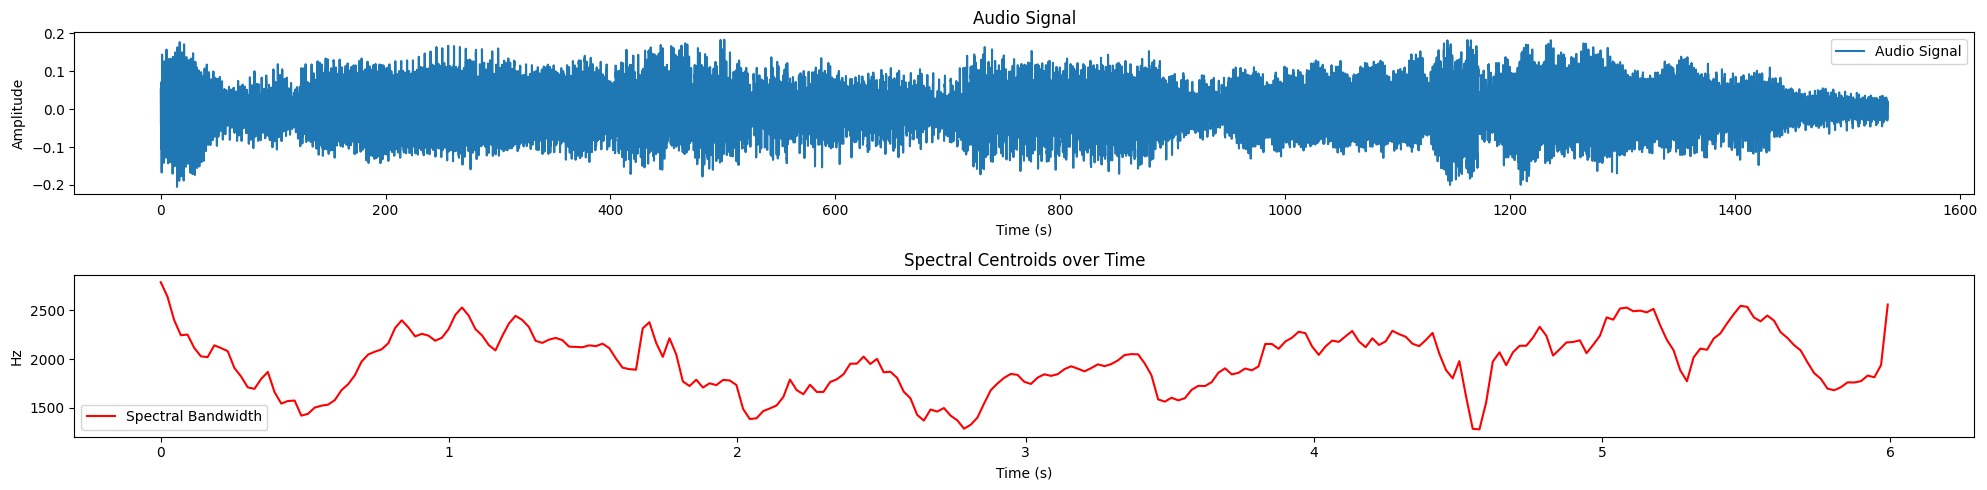

In [21]:
#Spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(y=sample, sr=sampling_rate)[0]

# Computing the time variable for visualization
plt.figure(figsize=(20,5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plot the audio signal
plt.subplot(2, 1, 1)
plt.plot(librosa.times_like(sample, sr=sampling_rate), sample, label='Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.legend()

# Plot the spectral bandwidth
plt.subplot(2, 1, 2)
plt.plot(t, spectral_centroids, label='Spectral Bandwidth', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.title('Spectral Centroids over Time')
plt.legend()

plt.tight_layout()
plt.show()

### 2.2.3 Bandwidth

The bandwidth captures the variance around spectral centroid.

![title](images/bandwidth.png)

The `librosa` libary provides an implementation at `librosa.feature.spectral_bandwidth`.

In [22]:
# import librosa implementation

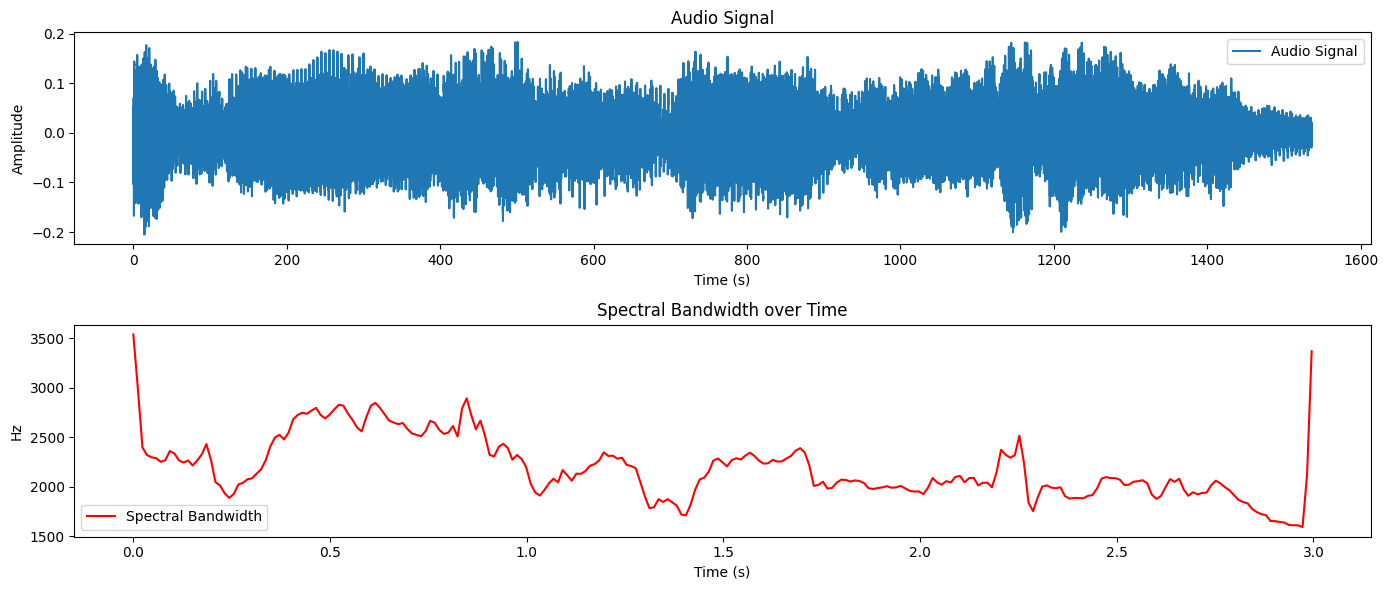

In [23]:
# compute bandwidth for your signal
spec_bw = librosa.feature.spectral_bandwidth(y=sample, sr=sampling_rate)[0]
times = librosa.times_like(spec_bw, sr=sampling_rate)

plt.figure(figsize=(14, 6))

# Plot the audio signal
plt.subplot(2, 1, 1)
plt.plot(librosa.times_like(sample, sr=sampling_rate), sample, label='Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.legend()

# Plot the spectral bandwidth
plt.subplot(2, 1, 2)
plt.plot(times, spec_bw, label='Spectral Bandwidth', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.title('Spectral Bandwidth over Time')
plt.legend()

plt.tight_layout()
plt.show()

### 2.2.4 Mel Frequency Cepstral Coefficients

MFCC maps frequency magnitudes to the more perceptually relevant Mel frequencies. The mapping between frequency and Mel frequency is as follows.

![title](images/mel_freq.png)

This mapping is not a simple conversion. More information on exactly how this is achieved can be found [here](https://www.youtube.com/watch?v=9GHCiiDLHQ4)

The `librosa` libary provides an implementation at `librosa.feature.mfcc`.

In [24]:
# import librosa implementation

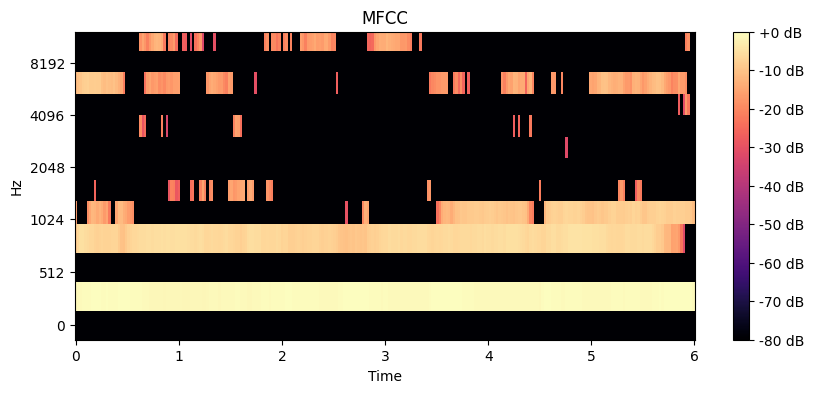

In [25]:
# compute MFCC coefficients for your signal
# Extract MFCCs
mfccs = librosa.feature.mfcc(y=sample, sr=sampling_rate, n_mfcc=13)  # You can adjust the number of MFCC coefficients (n_mfcc)

# Save MFCCs as a CSV file
mfccs_df = pd.DataFrame(mfccs)

plt.figure(figsize=(10, 4))

librosa.display.specshow(librosa.power_to_db(mfccs, ref=np.max), y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')

plt.title('MFCC')

plt.show()

## 2.3 Pitch Curve Features

Here we will extract the pitch curve features of:

- Max Pitch
- Min Pitch
- Pitch Range
- Number of Change Points

### 2.3.1 Load or Extract Pitch Track

Some pitch features are best extracted from the time series of the predominant vocal pitch. If you already have the pitch curve extracted you should load it to a `numpy.array` of pitch and time values... `[(pitch, time),..]`

Hint: You can load csv or tsv using `pandas.read_csv`

Hint: To extract values to a numpy array from a pandas dataframe (`df`) column you can use `df['colname'].values`

In [38]:
import math

def pitch_to_cents(pitch: float) -> float:
    if pitch <= 0:
        raise ValueError("Pitch must be a positive number.")
    return 1200 * math.log2(pitch / 440.0)

# Example usage
try:
    pitch = 880.0  # Example pitch in Hz
    cents = pitch_to_cents(pitch)
    print(f"The pitch {pitch} Hz is {cents} cents relative to A4 (440 Hz).")
except ValueError as e:
    print(e)

The pitch 880.0 Hz is 1200.0 cents relative to A4 (440 Hz).


In [27]:
# load pitch curve to pandas dataframe or numpy array
pitch_file_path = '../../../data/raw/Koti Janmani/Koti Janmani.pitch.txt'

pitch_file = pd.read_csv(pitch_file_path, sep="\t", header=None)
pitch_file.columns = ["time", "pitch"]


Or alternatively extract the pitch curve using an existing implementation

Hint: the `compiam` library has two pitch extractors implemented, `melodia` and `ftanet`. Each takes as an input the path (`vocal_path`) to the audio for which you want to extract the predominant pitch curve.

```
from compiam.melody.pitch_extraction import FTANetCarnatic
from compiam.melody.pitch_extraction import Melodia

melodia = Melodia() # initialise model
ftanet = FTANetCarnatic() # initialise model

melodia_pitch_track = melodia.extract(vocal_path)

# melodia
pitch = melodia_pitch_track[:,1]
time = melodia_pitch_track[:,0]
```

Hint: Are you using the vocal stem or the mixed track? Have you applied source separation? Make sure to listen to the audio beforehand to ensure the quality.

In [36]:
# extract pitch curve from path

time = pitch_file["time"].values

pitch = pitch_file["pitch"].values

timestep = time[1] - time[0]

### 2.3.2 Plot Pitch Curve

Are you able to plot a portion of this pitch curve?... frequency against time

**Hint**: As above, `maplotlib.pyplot` will be useful here

In [29]:
# THIS IS LIKE THE GET_OBSERVATION FILE
# First we have to get the sample, same as with the audio file, from 22 to 25 seconds
start = round(22 / timestep)
end = round(25 / timestep)

time_sample = time[start:end]
pitch_sample = pitch[start:end]

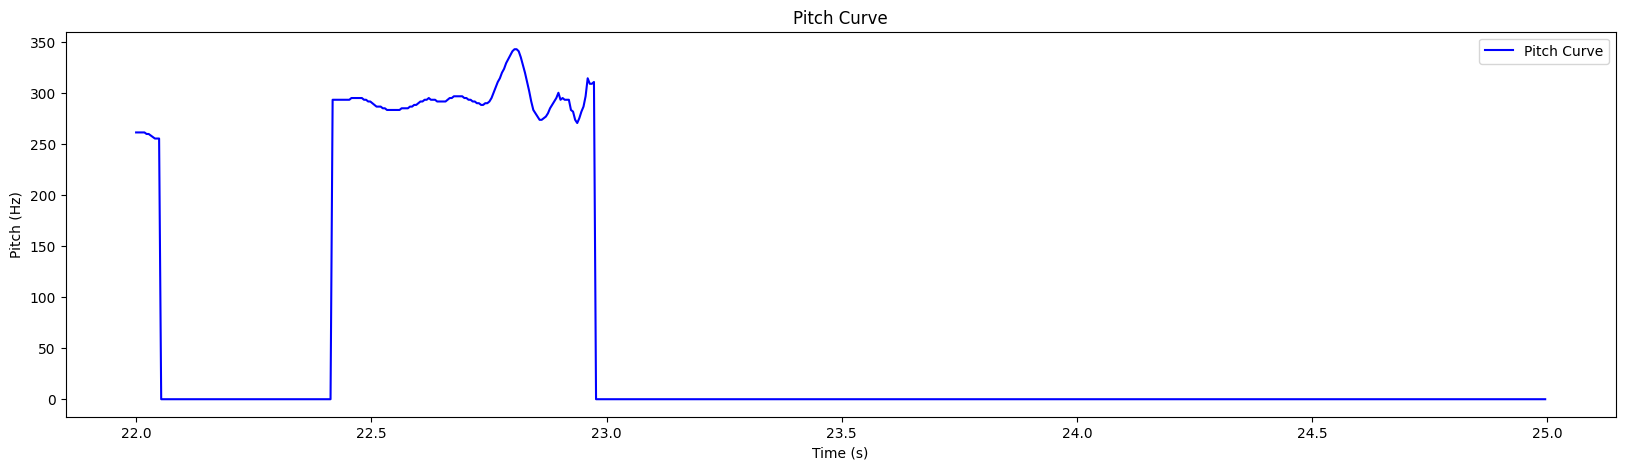

In [30]:
# plot portion of pitch curve
plt.figure(figsize=(20, 5))
plt.plot(time_sample, pitch_sample, color='blue', label='Pitch Curve')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title('Pitch Curve')
plt.legend()
plt.show()

### 2.3.3 Pre-process Pitch Curve

How does the pitch curve look. Do you need to apply some processing?

**Hint**: You may look at `scipy.signal.savgol_filter` for smoothing

**Hint**: To convert a frequency to cents above some reference point you can use the equation: `1200*log(f/ref, 2)` where `f` is the frequency and `ref` is the reference frequency, usually the performer tonic

**Hint**: Are there any small erroneous gaps in the pitch curve? Perhaps listening to the audio might serve as a useful guide. If necessary you might want to interpolate these small gaps. `pd.Series.interpolate` has the ability to interpolate nan values, you must first replace the points in the curve that you want to interpolate with nan values.

In [48]:
from pandas import Series

In [49]:
# processing steps

# convert pitch to cents
pitch = pd.Series(pitch)
pitch_interpolated = pitch.interpolate(method='linear')
cents = np.array([pitch_to_cents(p) for p in pitch_interpolated])

### 2.3.4 Min/max Pitch and Range

With the pitch curve clean and smoothed, it should be relatively simple to identify max pitch, min pitch and pitch range.

**Hint**: `numpy.min()` and `numpy.max()` may be useful here

In [50]:
# extract minimum pitch
min_pitch = np.min(cents)

In [51]:
# extract maximum pitch
max_pitch = np.max(cents)

In [52]:
# compute pitch range
pitch_range = max_pitch - min_pitch

### 2.3.4 Number of Change Points

Identify change points (points of zero derivative) is slightly more complicated. We are interested in points at which the pitch curve changes direction. 

**Hint**: `scipy.signal.find_peaks()` should be sueful here, be sure to read the documentation, the most important parameter will be `prominence`

**Hint**: `scipy.signal.find_peaks()` only identifies peaks in the pitch curve, but what about troughs? Flipping the curve in the y-direction before passing it to the function will convert peaks to troughs

**Hint**: The following link contains a visual guide to `find_peaks()` parameters - https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy

**Hint**: Peaks or troughs with a topographic prominence (see `find_peaks` documentation) of below around 70 cents could reasonably be discounted as vibrato rather than ornamentation owing to musically meaningful gamaka

**Hint**: Be sure to plot your curve with the idenified peaks to ensure it is working correctly

In [ ]:
# Identify number of change points in pitch curve

## 2.4 Extracting features across the dataset

Now that you are able to extract features for one individual sample. Let's apply this to the entire dataset.

In [ ]:
# list of filepaths to process

For each filepath, load the audio sample and apply the feature extractors defined above. Make sure to store these features in a dataframe with columns=\[`index`,`feature1`,`feature2`,`feature3`,...\].

**Hint**: `pandas.DataFrame` initialises a new dataframe

**Hint**: `df.append` appends new rows to a pandas dataframe

In [ ]:
# iterate through df
# extract features
# store in new features dataframe

Store this features dataframe alongside the original dataset

**Hint**: `df.to_csv` writes a dataframe to csv file

In [ ]:
# write dataframe